# GSWDesign.jl Walkthrough
GSWDesign is a Julia package which contains a fast implementation of the Gram--Schmidt Walk for balancing covariates in randomized experiments.
In this notebook, we demonstrate how to use its main functionality, the function `sample_gs_walk`, which is an efficient method for sampling from the Gram--Schmidt Walk design. 

This notebook **does not contain** any statistical analysis of this Gram--Schmidt Walk design nor code to construct average treatment effect estimates or confidence intervals. For those more technical aspects of this work, please see our paper,
1. Christopher Harshaw, Fredrik S&auml;vje, Daniel Spielman, Peng Zhang. "Balancing covariates in randomized experiments using the Gram–Schmidt walk". arxiv 1911.03071, 2019. [arxiv link](https://arxiv.org/abs/1911.03071)

In [1]:
# import other packages that we will use
using PyPlot
using Random

## Creating covariates
Let's begin by creating a toy dataset of $n=40$ units, each with a $d=2$-dimensional covariate vector.
We'll store these covariates as *rows* in a matrix `X`. This row convention is used in GSWDesign.
For an interesting dataset, we'll sample covariates from a mixture of Gaussians.

In [2]:
# begin by setting a random seed
Random.seed!(1234) 

# initialize matrix of covariates
num_gauss = 4
samples_per_gauss = 10
n = num_gauss * samples_per_gauss
d = 2
X = zeros(n,d)

# create covariates via mixture of Gaussians
mean_vecs = [1.0 1.0; -1.0 1.0; -1.0 -1.0; 1.0 -1.0]
for i=1:num_gauss
    for j=1:samples_per_gauss
        X[(i-1)*samples_per_gauss + j,:] = randn(d) + 3*mean_vecs[i,:]
    end
end

Let's plot the covariate vectors.

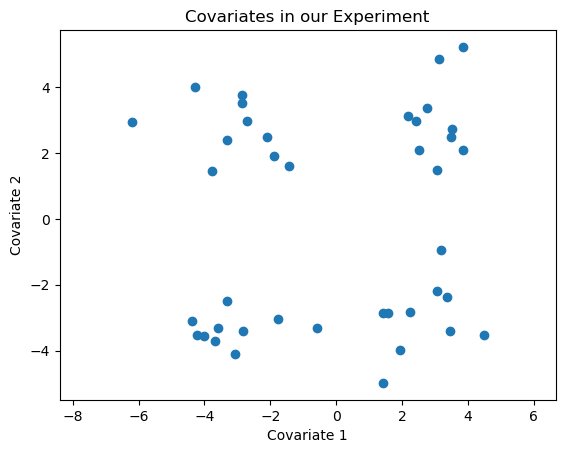

PyObject Text(0.5, 1.0, 'Covariates in our Experiment')

In [3]:
# plot covariate vectors
scatter(X[:,1], X[:,2])
xlabel("Covariate 1")
ylabel("Covariate 2")
axis("equal")
title("Covariates in our Experiment")

## Covariate Balancing
The $n$ units can be assigned into two treatment groups in various ways. A popular method, known as the *Bernoulli design* is to independently assign units to either of the two treatment groups with equal probability.
This method does not take covariates into account at all. 
Moreover, this design can have the undesirable effect of yielding assignments which do not "balance" covariates.
Let's see an example of this.

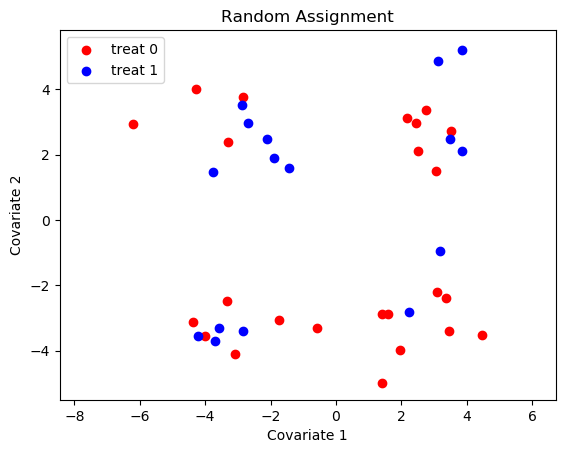

PyObject Text(0.5, 1.0, 'Random Assignment')

In [4]:
# generate a uniformly random assignment
z = rand([0,1], n)

# function to plot assignments
function plot_assignment(X, z, title_str)
    cols = ["red", "blue"]
    for a in [0,1]
        ind = findall(z .== a)
        lab_str = "treat $a"
        scatter(X[ind,1], X[ind,2], c=cols[a+1], label=lab_str)
    end
    legend()
    xlabel("Covariate 1")
    ylabel("Covariate 2")
    axis("equal")
    title(title_str)
end

# plot these assignments
plot_assignment(X, z, "Random Assignment")

We can observe the covariate imbalance in the upper left group and the lower right group. The upper left group has an more units assigned to treatment 1 while the lower right group has more units assigned to treatment 2. By the "law of small numbers" this covariate imbalance is likely to happen for uniformly random assignments.

The Gram--Schmidt Walk design attempts to correct this issue by producing random assignemnts of units for which the covariates are balanced. Again, we won't attempt to discuss the technical aspects here, as we are mainly interested in demonstrating how to run the package.

The function to sample from the Gram--Schmidt Walk design is `sample_gs_walk(X, lambda, ...)` which has two reqiuired input arguments
1. `X` is an $n$-by-$d$ matrix of covariates
2. `lambda` is a design parameter in $(0,1]$ which determines the level of covariate balance.

When `lambda` is set to `1`, then the algorithm assignments treatments independently, and as `lambda` decreases, the level of covariate balance increases. We will discuss optional arguements later in this tutorial. The default output argument is a length $n$ assignment vector with $0/1$ entries.

In [ ]:
using GSWDesign

# sample assignment from the design
lambda = 0.5
z = sample_gs_walk(X, lambda)

# plot this assignment
plot_assignment(X, z, "GSW Design with lambda=$lambda")

Notice now that each of the four groups has nearly equal balance. This covariate balance occurs with much higher probability when sampling assignments from the Gram--Schmidt walk design than sampling assignments uniformly at random. As mentioned previously, the level of balance can be controlled by the input parameter `lambda`.

## Multiple Samples
To sample more than one assignment from the Gram--Schmidt walk design, set the optional parameter `num_samples`. When `num_samples` is larger than 1, the output is a two-dimensional array with assignments as rows and units as columns.

In [ ]:
lambda = 0.5
assignment_list = sample_gs_walk(X, lambda, num_samples=9)

Certain computations are re-used when `num_samples` is set larger than `1`. For this reason, it's better to call `sample_gs_walk` once with the arguement `num_samples=k` rather than calling `sample_gs_walk` `k` separate times.

## Marginal Treatment Probabilities
By default, the Gram--Schmidt design has the property that marginal treatment probailities are equal between units and treatments. That is, 
$$ 
\Pr \left( \text{unit $i$ is assigned treatment 0} \right) =  
\Pr \left( \text{unit $i$ is assigned treatment 1} \right) = 
1/2
\quad \text{for all units } i=1, 2, \dots n \enspace.
$$
However, the Gram--Schmidt Walk supports setting arbitrary marginal treatment probabilities. In particular, the marginal treatment probabilities can be set to values other than $1/2$ and can also differ across units. Of course, this has implications for covariate balancing but we refer the reader to our paper.

Setting different marginal treatment probabilities may be done using the optional arguement `treatment_probs`.
To use it, first construct `p` to be a length $n$ array where `p[i]` is the probability that unit `i` is assigned treatment 1.
Then call `sample_gs_walk(X, lambda, treatment_probs=p)`.

We show how to do this below.

In [ ]:
# select treatment probabilities on a linear scale from (0,1)
p = Array(range(0.1,stop=0.9,length=n))

# sample 1 assignment
lambda = 0.5
z = sample_gs_walk(X, lambda, treatment_probs=p)

We can see that the earlier assignments are mostly `0`, while later assignments are mostly `1`, which is an indication that the code is working as advertised. To get a better sense of this, let's collect many samples and then plot the empirical probabilities of assignment to treatment 1.

In [ ]:
assignment_list = sample_gs_walk(X, lambda, treatment_probs=p, num_samples=500)
empirical_mean = reshape(sum(assignment_list, dims=1),n) / 500

scatter(1:n, empirical_mean)
xlabel("Units")
ylabel("Empirical Probability of Treatment 1")

## Balanced Gram--Schmidt Walk
In randomized experiments, it is often desirable to ensure that an equal number of units are assigned to each treatment. Just as this is not guaranteed by independent assignment, this is not guaranteed by the Gram--Schmidt Walk design. However, a slight modification to the sampling algorithm does ensure that this condition holds. To sample from the balanced Gram--Schmidt Walk design, simply call `gs_walk_design` with `balance=true`.

In [ ]:
# no balance
assignment_list = sample_gs_walk(X, lambda, num_samples=200)
treatment_size_diff = abs.(sum(assignment_list .- 0.5, dims=2))
println("GSW: maximum assignment imbalance is ", maximum(treatment_size_diff))

# balance
assignment_list = sample_gs_walk(X, lambda, num_samples=200, balanced=true)
treatment_size_diff = abs.(sum(assignment_list .- 0.5, dims=2))
println("GSW: maximum assignment imbalance is ", maximum(treatment_size_diff))